<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=140936080" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
from spx_strategies import *
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
purchase_time = '16:00:00'
# In dollars
commission = 1.5



files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    raise Exception("dte must be present")

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-18-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-22-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-23.db
Copying db file to output :

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
    for f in filenames:
        if 'spx' in f:
            df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df.rename(columns={'underlying':'price'},inplace=True)
            df.drop(columns=['Unnamed: 0'], inplace=True)
            df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
            df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
            df['delta'] = df['delta'].abs()
            initial_portfolio_value = df.loc[1,'price']*20
        elif 'irx' in f:
            df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
            df_irx['Adj Close']*= 100
            df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
            df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
            df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
            df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)



In [3]:
df[(df['expiration']=='2023-08-18')&(df['quote_time']=='09:31:00')&(df['strike']==4400)]

,bid,ask,strike,expiration,price,iv,delta,type,quote_time,quote_date,dte
7573378,27.10,28.10,4400.0,2023-08-18,4404.33,0.241884,0.535437,C,09:31:00,2023-08-17,1
7573379,6.20,6.60,4400.0,2023-08-18,4404.33,0.083896,0.405804,P,09:31:00,2023-08-17,1
7573380,31.00,31.40,4400.0,2023-08-18,4404.33,0.276170,0.531801,C,09:31:00,2023-08-17,1
7573381,10.00,10.20,4400.0,2023-08-18,4404.33,0.120522,0.433390,P,09:31:00,2023-08-17,1
8303498,0.00,6.50,4400.0,2023-08-18,4370.36,0.293341,0.200905,C,09:31:00,2023-08-18,0
8303499,20.60,49.40,4400.0,2023-08-18,4370.36,0.253820,0.834001,P,09:31:00,2023-08-18,0
8303500,0.45,0.55,4400.0,2023-08-18,4370.36,0.160348,0.061917,C,09:31:00,2023-08-18,0
8303501,57.40,58.10,4400.0,2023-08-18,4370.36,0.867753,0.607560,P,09:31:00,2023-08-18,0


# Backtest Optimization

In [4]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [5]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return On Scaled Max Risk']

In [6]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.45)
    delta_lp_trial = trial.suggest_float("delta_lp", 0.002, 0.45)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.45)
    delta_lc_trial = trial.suggest_float("delta_lc", 0.002, 0.45)
    
    if (delta_lp_trial >= delta_sp_trial) or (delta_lc_trial >= delta_sc_trial):
        return -1
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    dos = DeltaOptionSelector(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
    ex_pol = HoldToExpStaticExitPolicy('16:00:00')

    strategy = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [7]:
study_name = f"optimal-short-ic-study_2023-2023_1DTE_{datetime.today().strftime('%Y-%m-%d-%H')}"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 10)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-08-24 22:46:34,101] Using an existing study with name 'optimal-short-ic-study_2023-2023_1DTE_2023-08-24-22' instead of creating a new one.
[I 2023-08-24 22:46:37,924] Trial 10 finished with value: 0.925 and parameters: {'delta_sp': 0.4392328326445284, 'delta_lp': 0.3139313901677639, 'delta_sc': 0.29762271658112993, 'delta_lc': 0.22906523206185747}. Best is trial 0 with value: 0.943.
[I 2023-08-24 22:46:41,674] Trial 11 finished with value: 0.95 and parameters: {'delta_sp': 0.43905781808374417, 'delta_lp': 0.2942734873856038, 'delta_sc': 0.29942712000341165, 'delta_lc': 0.22400046261340775}. Best is trial 11 with value: 0.95.
[I 2023-08-24 22:46:45,450] Trial 12 finished with value: 0.945 and parameters: {'delta_sp': 0.3514010365347466, 'delta_lp': 0.3178642192004232, 'delta_sc': 0.29371970678039677, 'delta_lc': 0.1982449820229997}. Best is trial 11 with value: 0.95.
[I 2023-08-24 22:46:45,596] Trial 13 finished with value: -1.0 and parameters: {'delta_sp': 0.338781428945929, 'd

Best Score:  1.026
Best Params: 
  delta_lc: 0.06406690623009455
  delta_lp: 0.0754938646266152
  delta_sc: 0.43595052235515186
  delta_sp: 0.19660415588231256


# Backtest with current best score

*****  BACKTEST RESULTS  ****

Cumulative return:                      4.928 % 
Max Drawdown:                          -2.819 % 
Trading Days:                              29 
Wins:                                      19 
Losses:                                    10 
Breakeven:                                  0 
Win/Loss Ratio:                        65.517 % 
Mean Win:                             904.684 $ 
Mean Win Trans Return:                  0.981 % 
Mean Loss:                           -1274.35 $ 
Mean Loss Trans Return:                -1.411 % 
Mean Net Trans:                       153.293 $ 
Mean Trans Return:                      0.212 % 
Std Dev of Net Trans:                1227.986 
Std Dev of Trans Return:                0.013 
Max Loss:                             -3269.0 $ 
Max Win:                               1529.0 $ 
Sharpe Ratio static STD:                  2.3 
Sharpe Ratio with RF STD:                 2.3 
Risk Adj Cumulative Return:            373.65 
Dampene

,trade_date,expiration,trade_count,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,0.196604,4480.0,0.178156,257.5,0.435951,4510.0,0.419038,780.0,0.064067,4545.0,0.054438,-60.0,0.075494,4460.0,0.070176,-95.0,882.5,1669.0,0.0,4526.69,6.0,1669.0,-792.5,89408.3,-792.5,NaN,-0.008786,0.000207,3500.0,2617.5,-0.302770,0.993945
1,2023-07-17,2023-07-18,4.0,0.196604,4500.0,0.165757,250.0,0.435951,4535.0,0.351153,467.5,0.064067,4565.0,0.046318,-45.0,0.075494,4480.0,0.061528,-85.0,587.5,2332.0,0.0,4558.32,6.0,2332.0,-1750.5,87657.8,-2543.0,-0.019579,-0.028193,0.000208,3000.0,2412.5,-0.725596,0.985488
2,2023-07-18,2023-07-19,4.0,0.196604,4535.0,0.192177,295.0,0.435951,4565.0,0.394381,617.5,0.064067,4600.0,0.052183,-55.0,0.075494,4515.0,0.074479,-105.0,752.5,348.0,0.0,4568.48,6.0,348.0,398.5,88056.3,-2144.5,0.004546,-0.023775,0.000208,3500.0,2747.5,0.145041,1.002901
3,2023-07-19,2023-07-20,4.0,0.196604,4540.0,0.166846,270.0,0.435951,4575.0,0.418772,855.0,0.064067,4615.0,0.061070,-80.0,0.075494,4520.0,0.072510,-110.0,935.0,0.0,599.0,4534.01,6.0,599.0,330.0,88386.3,-1814.5,0.003748,-0.020116,0.000208,4000.0,3065.0,0.107667,1.002153
4,2023-07-20,2023-07-21,4.0,0.196604,4510.0,0.177861,257.5,0.435951,4540.0,0.430633,942.5,0.064067,4570.0,0.061856,-62.5,0.075494,4500.0,0.075295,-85.0,1052.5,0.0,0.0,4537.79,6.0,0.0,1046.5,89432.8,-768.0,0.011840,-0.008514,0.000208,3000.0,1947.5,0.537356,1.010747
5,2023-07-21,2023-07-24,4.0,0.196604,4510.0,0.153185,232.5,0.435951,4545.0,0.414824,717.5,0.064067,4580.0,0.050204,-50.0,0.075494,4495.0,0.072015,-100.0,800.0,782.0,0.0,4552.82,6.0,782.0,12.0,89444.8,-756.0,0.000134,-0.008381,0.000208,3500.0,2700.0,0.004444,1.000089
6,2023-07-24,2023-07-25,4.0,0.196604,4530.0,0.169521,225.0,0.435951,4560.0,0.406195,785.0,0.064067,4595.0,0.049138,-50.0,0.075494,4510.0,0.062230,-80.0,880.0,1138.0,0.0,4571.38,6.0,1138.0,-264.0,89180.8,-1020.0,-0.002952,-0.011308,0.000208,3500.0,2620.0,-0.100763,0.997985
7,2023-07-25,2023-07-26,4.0,0.196604,4530.0,0.187364,495.0,0.435951,4580.0,0.425915,1290.0,0.064067,4635.0,0.061831,-110.0,0.075494,4500.0,0.065590,-140.0,1535.0,0.0,0.0,4566.59,6.0,0.0,1529.0,90709.8,509.0,0.017145,0.005643,0.000209,5500.0,3965.0,0.385624,1.007712
8,2023-07-26,2023-07-27,4.0,0.196604,4540.0,0.167403,252.5,0.435951,4575.0,0.403442,892.5,0.064067,4615.0,0.042779,-50.0,0.075494,4520.0,0.071739,-105.0,990.0,0.0,623.0,4533.77,6.0,623.0,361.0,91070.8,870.0,0.003980,0.009645,0.000209,4000.0,3010.0,0.119934,1.002399
9,2023-07-27,2023-07-28,4.0,0.196604,4495.0,0.173930,400.0,0.435951,4545.0,0.405842,1255.0,0.064067,4600.0,0.051577,-87.5,0.075494,4460.0,0.071504,-165.0,1402.5,3372.0,0.0,4578.72,6.0,3372.0,-1975.5,89095.3,-1105.5,-0.021692,-0.012256,0.000209,5500.0,4097.5,-0.482123,0.990358


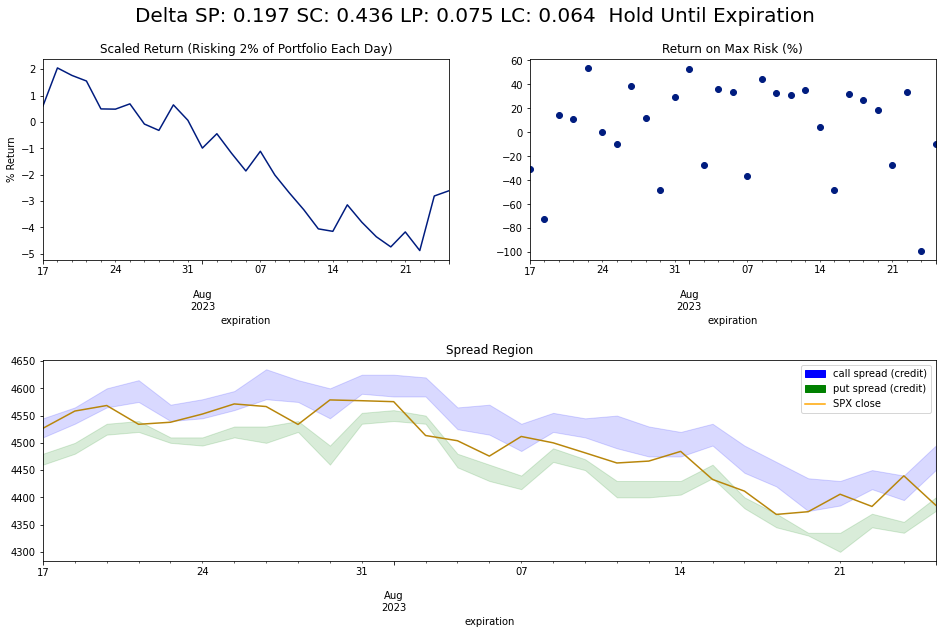

In [8]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'], long_puts=trial.params['delta_lp'],long_calls=trial.params['delta_lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy('16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [9]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [10]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-08-24,2023-08-25,0.196604,4335.0,0.169277,492.5,0.435951,4395.0,0.403471,1015.0,2,1507.5


# Strikes following the 4/2 Strategy

In [11]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-08-24,2023-08-25,0.04,4290.0,0.038923,85.0,0.02,4480.0,0.017661,25.0,2,110.0
